# HW1 - Classifiers

## 1. Digit Recognizer

In [140]:
# import libraries
import numpy as np
import pandas as pd
import random

# read training and testing data
training_data=pd.read_csv("train.csv")
testing_data=pd.read_csv("test.csv")


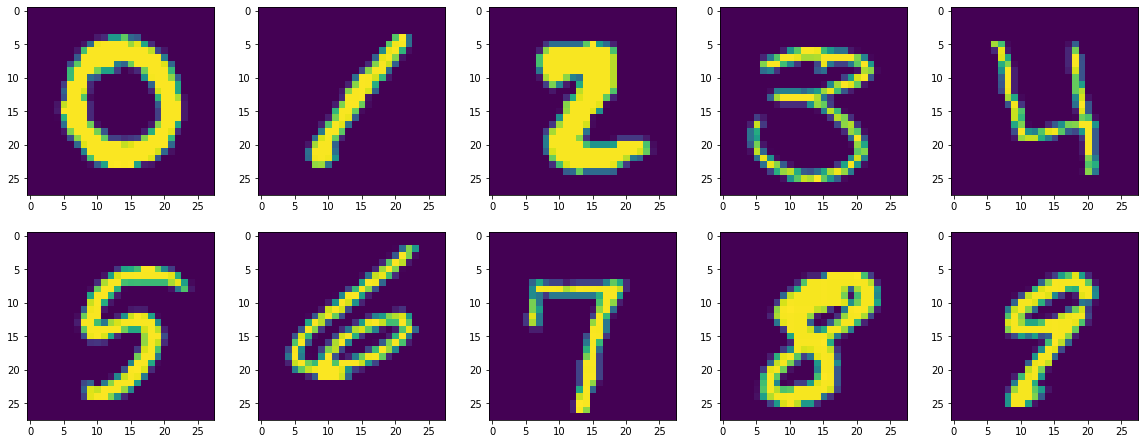

In [141]:
labels=training_data['label'].values #extract data labels
data=training_data.drop(['label'],axis=1).values # extract data values
data = data.reshape(-1,28,28) # shape data for display

# plot one of each digit

plt.figure(figsize=(20,20))
plt.subplot(5,5,1)
displayDigit(0)
plt.subplot(5,5,2)
displayDigit(1)
plt.subplot(5,5,3)
displayDigit(2)
plt.subplot(5,5,4)
displayDigit(3)
plt.subplot(5,5,5)
displayDigit(4)
plt.subplot(5,5,6)
displayDigit(5)
plt.subplot(5,5,7)
displayDigit(6)
plt.subplot(5,5,8)
displayDigit(7)
plt.subplot(5,5,9)
displayDigit(8)
plt.subplot(5,5,10)
displayDigit(9)

In [185]:
# function to display the MNIST digit indicated by the label parameter
def displayDigit(label):
    digitIndex = list(labels).index(label)
    imshow(data[digitIndex,:,:])
    return null
  
# function to calculate the prior probability of the class indicated by the label parameter
def calculatePrior(label):
    return np.count_nonzero(labels == label)/42000

# function to calculate the number of times an element of the class indicated by the label parameter appears
def counts(label):
    return np.count_nonzero(labels == label)

Prior probability 0:  0.098
Prior probability 1:  0.112
Prior probability 2:  0.099
Prior probability 3:  0.104
Prior probability 4:  0.097
Prior probability 5:  0.09
Prior probability 6:  0.099
Prior probability 7:  0.105
Prior probability 8:  0.097
Prior probability 9:  0.1


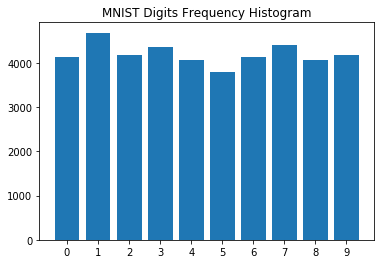

In [204]:
prior0 = calculatePrior(0)
prior1 = calculatePrior(1)
prior2 = calculatePrior(2)
prior3 = calculatePrior(3)
prior4 = calculatePrior(4)
prior5 = calculatePrior(5)
prior6 = calculatePrior(6)
prior7 = calculatePrior(7)
prior8 = calculatePrior(8)
prior9 = calculatePrior(9)

print('Prior probability 0: ', round(prior0,3))
print('Prior probability 1: ', round(prior1,3))
print('Prior probability 2: ', round(prior2,3))
print('Prior probability 3: ', round(prior3,3))
print('Prior probability 4: ', round(prior4,3))
print('Prior probability 5: ', round(prior5,3))
print('Prior probability 6: ', round(prior6,3))
print('Prior probability 7: ', round(prior7,3))
print('Prior probability 8: ', round(prior8,3))
print('Prior probability 9: ', round(prior9,3))

x = np.arange(10)
plt.bar(x, height= [counts(0), counts(1), counts(2), counts(3), counts(4), counts(5), counts(6), counts(7), counts(8), counts(9)]) 
plt.xticks(x, ['0','1','2', '3', '4', '5', '6', '7', '8', '9'])
plt.title('MNIST Digits Frequency Histogram')
plt.show()

## 2. The Titanic Disaster